In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn.linear_model as sklm
import sklearn.pipeline
import sklearn.model_selection as skms
import sklearn.feature_selection 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# Import our filess
from load_train_data import load_data 
from clean_tokens import lemmetize2

In [ ]:
import nltk
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.corpus import webtext, brown
from nltk import ngrams, FreqDist
from nltk.stem import WordNetLemmatizer

# Outline
* [Part 1: Clean Tokens](#part1)
* [Part 2: Retrieve Initial Best Params](#part2)
* [Part 3: Misclassification on Training Set](#part3)
* [Part 4: Fine Search for Each Hyperparameter](#part4)
* [Part 5: Visualizing Effect of Varied C and Max Iteration on AUROC Score](#part5)

<a id='part1'></a>
# Clean Tokens: 

Loading data from csv files

In [43]:
website_list, review_list, rating_list = load_data('x_train.csv', 'y_train.csv')

In [48]:
#dividing reviews by website:
yelp_reviews = list()
imdb_reviews= list()
amazon_reviews = list()

for i in range(len(website_list)):
    if website_list[i] == 'yelp':
        yelp_reviews.append(review_list[i])
    elif website_list[i] == 'imdb':
        imdb_reviews.append(review_list[i])
    elif website_list[i] == 'amazon':
        amazon_reviews.append(review_list[i])

Making a custom list of words to remove from tokens. A combined list of stopwords from NLTK library and observed non-predictive words. 

In [49]:
stoppedWords = stopwords.words('english')
added_words = ["i've", "i'd", "i'm", "that's", "i'll", "was", "as", "us", "was", "as"]
stoppedWords.extend(added_words)

In [ ]:
final = lemmetize2(review_list)

<b id='part2'></b>
# Coarse hyperparameter search 
Trying following parameters:
* Regularization strength C: 0.1 to 20
* penalty: L1, L2
* max iterations: 80 to 100
* Number of folds for cross validation = 5

In [ ]:
logistic = sklm.LogisticRegression(solver='liblinear', max_iter=250)
distributions = dict(C=np.logspace(np.log10(0.1),np.log10(20), 200), penalty = ['l1', 'l2'])

#Pipeline starts!
p2_bow_classifier_pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(token_pattern='\w+', min_df= 1, ngram_range=(1, 2))),
    ('cross validation', skms.RandomizedSearchCV(logistic, distributions, n_iter=300, cv=5, verbose=0, 
                                                 random_state=0, error_score='raise', 
                                                 return_train_score=True, scoring='roc_auc'))
])

# Final is the list of cleaned and lemmetized reviews
p2_bow_classifier_pipeline.fit(final, rating_list)
p2_bow_classifier_pipeline.predict(final)
p2_bow_classifier_pipeline.score(final, rating_list)

In [ ]:
print(p2_bow_classifier_pipeline['cross validation'].best_params_)

In [55]:
yhat2 = p2_bow_classifier_pipeline.predict(final)
yhatProbs2 = p2_bow_classifier_pipeline.predict_proba(final)

for Idx in np.arange(len(yhat2)):
    if yhat2[Idx] != rating_list[Idx]:
        print('True %s|%s Pred| %1.3f| %s| %s' % (rating_list[Idx], yhat2[Idx], yhatProbs2[Idx][1], review_list[Idx], final[Idx]))

In [56]:
my_dict = p2_bow_classifier_pipeline['my_bow_feature_extractor'].vocabulary_

<c id='part3'></c>
# Misclassifications on Training Set
Visualizing which reviews were misclassified to improve the AUROC score

In [ ]:
yhat = p2_bow_classifier_pipeline.predict(review_list)
yhatProbs = p2_bow_classifier_pipeline.predict_proba(review_list)
print(yhat)

for revIdx in np.arange(len(yhat)):
    if yhat[revIdx] != rating_list[revIdx]:
        print('True %s|%s Pred| %1.3f| %s' % (rating_list[revIdx], yhat[revIdx], yhatProbs[revIdx][1], review_list[revIdx]))

<d id='part4'></d>
# Evaluate on Test Data
Trying out our current best hyperparameters on the test set to see actual performance.

In [ ]:
x_te_data = 'x_test.csv'
data_dir = 'data_reviews'
x_te_df = pd.read_csv(os.path.join(data_dir, x_te_data))
te_website_list = x_te_df['website_name'].values.tolist()
te_text_list = x_te_df['text'].values.tolist()

print(te_text_list)
print(lemmetize2(te_text_list))
probs_p2 = p2_bow_classifier_pipeline.predict_proba(lemmetize2(te_text_list))[:, 1]
pred_p2 = p2_bow_classifier_pipeline.predict(lemmetize2(te_text_list))
# print(probs_p2)

y_te_data = 'y_test.csv'
data_dir = 'data_reviews'
y_te_df = pd.read_csv(os.path.join(data_dir, y_te_data))
te_rating_list = y_te_df['is_positive_sentiment'].values.tolist()

np.savetxt('yproba1_test_lemmatize_1gram.txt', probs_p2, fmt='%s')
# np.savetxt('yproba1_test.txt', pred_p2, fmt='%s')
q2_acc = roc_auc_score(te_rating_list, probs_p2)
real_acc = p2_bow_classifier_pipeline.score(te_text_list, te_rating_list)
print("Real accuracy: %.3f" % real_acc)
print("AUROC Score: %.3f" % q2_acc)

with open('q2_probs_again.txt', 'w') as f:
    f.write(str(q2_acc))
#a, b, c = roc_curve(te_rating_list, probs_p2)
#plt.plot(a, b)

<e id='part5'></e>
# Fine Search for Each Hyperparameter:
Using the best initial parameters from before, do a fine search of eac hyperparameter. 

In [60]:
optParams = p2_bow_classifier_pipeline['cross validation'].best_params_
print('Best parameters: ', optParams)
finalEstimator = p2_bow_classifier_pipeline.named_steps['cross validation'].best_estimator_

Best parameters:  {'penalty': 'l2', 'C': 20.000000000000004}


### Evaluating best C:

In [61]:
# Create a logistic regression classifier
logisticEvalHype = sklm.LogisticRegression(solver='liblinear',penalty=optParams['penalty'], max_iter=200)
# Hyperparameters distributions - regularization strength C
numFolds = 5
CDist = np.logspace(-9,6,40)
distEvalHype = dict(C = CDist) #[10**(-4), optParams['C'], 10**6])

#Pipeline starts!
evalHypeParamCPipe = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(min_df=1, max_df=0.08, ngram_range=(1,2))),
    ('cross validation', skms.GridSearchCV(logisticEvalHype, distEvalHype, cv=numFolds, verbose=0, 
                                                error_score='raise', scoring='roc_auc', return_train_score=True))
])

evalHypeParamCPipe.fit(review_list, rating_list)

Pipeline(steps=[('my_bow_feature_extractor',
                 CountVectorizer(max_df=0.08, ngram_range=(1, 2))),
                ('cross validation',
                 GridSearchCV(cv=5, error_score='raise',
                              estimator=LogisticRegression(max_iter=200,
                                                           solver='liblinear'),
                              param_grid={'C': array([1.00000000e-09, 2.42446202e-09, 5.87801607e-09, 1.42510267e-08,
       3.45510729e-08, 8.37677640e-08, 2.03091762e-07, 4.92388263e...
       1.42510267e-03, 3.45510729e-03, 8.37677640e-03, 2.03091762e-02,
       4.92388263e-02, 1.19377664e-01, 2.89426612e-01, 7.01703829e-01,
       1.70125428e+00, 4.12462638e+00, 1.00000000e+01, 2.42446202e+01,
       5.87801607e+01, 1.42510267e+02, 3.45510729e+02, 8.37677640e+02,
       2.03091762e+03, 4.92388263e+03, 1.19377664e+04, 2.89426612e+04,
       7.01703829e+04, 1.70125428e+05, 4.12462638e+05, 1.00000000e+06])},
                              return_train_score=True, scoring='roc_auc'))])

### Evaluating Best Max_iter:

In [ ]:
# Create a logistic regression classifier
logisticEvalHype = sklm.LogisticRegression(solver='liblinear',penalty=optParams['penalty'], C=optParams['C'])
# Hyperparameters distributions - regularization strength C
maxIterDist = np.logspace(np.log10(1),np.log10(50000),50, dtype=int)
distEvalHype = dict(max_iter = maxIterDist) 

#Pipeline starts!
evalHypeParamIterPipe = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(min_df=1, max_df=1.0, ngram_range=(1,2))),
    ('cross validation', skms.GridSearchCV(logisticEvalHype, distEvalHype, cv=5, verbose=0, 
                                                error_score='raise', scoring='roc_auc', return_train_score=True))
])


# Shuffle data
# (shuffleReviews, shuffledRatings) = shuffle(review_list, rating_list, random_state=0)
# evalHypeParamIterPipe.fit(shuffleReviews, shuffledRatings)
evalHypeParamIterPipe.fit(review_list, rating_list)

<f id='part6'></f>
# Visualizing Effect of Varied C and Max Iteration on AUROC Score:

(5, 40)


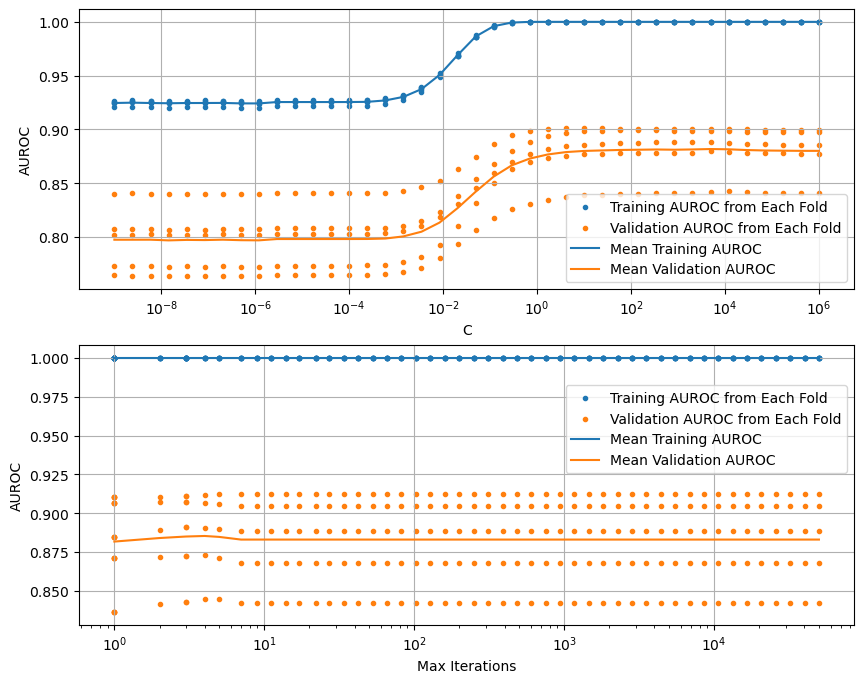

In [63]:
# Extract C data for plotting

CVars = evalHypeParamCPipe['cross validation'].cv_results_

C_Train = CVars['mean_train_score']
C_Val = CVars['mean_test_score']
C_TrainFolds = np.vstack((CVars['split0_train_score'], CVars['split1_train_score'], CVars['split2_train_score'], CVars['split3_train_score'], CVars['split4_train_score']))
C_ValFolds = np.vstack((CVars['split0_test_score'], CVars['split1_test_score'], CVars['split2_test_score'], CVars['split3_test_score'], CVars['split4_test_score']))
CDistFolds = np.tile(CDist, (numFolds,1))
print(CDistFolds.shape)

# Extract max_iter data for plotting
IterVars = evalHypeParamIterPipe['cross validation'].cv_results_

Iter_Train = IterVars['mean_train_score']
Iter_Val = IterVars['mean_test_score']
Iter_TrainFolds = np.vstack((IterVars['split0_train_score'], IterVars['split1_train_score'], IterVars['split2_train_score'], IterVars['split3_train_score'], IterVars['split4_train_score']))
Iter_ValFolds = np.vstack((IterVars['split0_test_score'], IterVars['split1_test_score'], IterVars['split2_test_score'], IterVars['split3_test_score'], IterVars['split4_test_score']))
IterDistFolds = np.tile(maxIterDist, (numFolds,1))

# Plot accuracy vs C and max_iter hyperparameters

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
ax1.scatter(CDistFolds, C_TrainFolds, label='Training AUROC from Each Fold',marker='.')
ax1.scatter(CDistFolds, C_ValFolds, label='Validation AUROC from Each Fold',marker='.')
ax1.plot(CDist, C_Train, label='Mean Training AUROC')
ax1.plot(CDist, C_Val, label='Mean Validation AUROC')
ax1.legend()
ax1.set_xlabel('C')
ax1.set_ylabel('AUROC')
ax1.set_xscale('log')
ax1.grid(which='both')

# fig, ax = plt.subplots()
ax2.scatter(IterDistFolds, Iter_TrainFolds, label='Training AUROC from Each Fold',marker='.')
ax2.scatter(IterDistFolds, Iter_ValFolds, label='Validation AUROC from Each Fold',marker='.')
ax2.plot(maxIterDist, Iter_Train, label='Mean Training AUROC')
ax2.plot(maxIterDist, Iter_Val, label='Mean Validation AUROC')
ax2.legend(loc='center right', bbox_to_anchor=(1, 0.7))
ax2.set_xlabel('Max Iterations')
ax2.set_ylabel('AUROC')
ax2.set_xscale('log')
ax2.grid(which='major')

# Different preprocessing attempts that led to worse AUROC scores:
* Considering review source - Tried separating the reviews by the website they were extracted from (e.g. Amazon, IMDB, and Yelp).
* n-grams and lemmenized words - Added a list of bigrams, trigrams, etc. to the tokens. 
* Parts of Speech - Tagged tokens in the review by parts of speech to remove adverbs.

# Separating text by website:

In [64]:
#Adding stopwords
stop_words = stopwords.words('english')
added_words = ["i've", "i'd", "i'm", "that's", "i'll", "was", "as"]
stop_words.extend(added_words) 

In [ ]:
#amazon tokens
amazon_tokenz = clean_tokens(tokenizing(amazon_reviews))

#imdb tokens
imdb_tokenz = clean_tokens(tokenizing(imdb_reviews))

#yelp tokens
yelp_tokenz = clean_tokens(tokenizing(yelp_reviews))

#all reiveiws:
all_tokenz = clean_tokens(tokenizing(review_list))

#printing words to file called q2_tokens.txt
with open('q2_tokens.txt', 'w') as f:
    f.write(str(all_tokenz))

# Looking at bigrams, trigrams, etc...

In [ ]:
#prints most common unigrams, bigrams, trigrams for any list of tokens
def common_tokens(the_reviews):
    all_counts = dict()
    for size in 1, 2:
        all_counts = FreqDist(ngrams(the_reviews, size))
    
    #print('unigrams:', all_counts[1].most_common(10))
    #print('bigrams:', all_counts[2].most_common(10))
    return all_counts
#Printing top 10 most common bigrams and trigrams
#Don't use anything above bigrams since the frequency is too low.

In [ ]:
#Looking at the most ommon unigrams, bigrams, trigrams for each website
all_common_tokenz = common_tokens(clean_tokens(all_tokenz))

In [ ]:
#For amazon. Already got rid of stopwords and punctuation.
common_amazon_tokenz = common_tokens(clean_tokens(amazon_tokenz))

In [ ]:
#For imdb. Already got rid of stopwords and punctuation.
common_imdb_tokenz = common_tokens(clean_tokens(imdb_tokenz))

In [ ]:
#For Yelp. Already got rid of stopwords and punctuation.
common_yelp_tokenz = common_tokens(clean_tokens(yelp_tokenz))

In [ ]:
#getting word frequency:
def freq_dict(review_tokens):
    word_freq = dict()

    for tok in review_tokens:
        if tok in word_freq:
            word_freq[tok] += 1
        else:
            word_freq[tok] = 1

    #sorting word frequency
    sorted_word_freq = list(sorted(word_freq, key=word_freq.get, reverse=True))
    print(sorted_word_freq[0:100])

In [ ]:
#100 most common tokens
freq_dict(all_tokenz)

['good', 'great', 'movie', 'phone', 'the', 'film', 'one', 'food', 'place', 'like', 'a', 'service', 'time', 'bad', 'really', 'would', 'well', 'even', 'ever', 'best', 'back', 'also', 'go', 'is', 'quality', 'love', 'made', 'product', 'excellent', 'better', 'recommend', 'work', 'sound', 'could', 'get', 'works', 'was', 'nice', 'very', 'use', 'much', 'headset', 'make', 'first', 'not', 'see', 'way', 'never', 'think', 'still', 'battery', 'pretty', 'i', 'disappointed', 'acting', 'little', 'every', 'characters', 'price', 'case', '10', 'enough', '2', 'worst', 'ear', 'amazing', 'right', 'have', 'waste', 'say', 'came', 'got', 'everything', 'two', 'going', 'definitely', 'movies', 'thing', 'money', 'minutes', 'had', 'real', 'know', 'terrible', 'far', 'plot', 'wonderful', 'poor', 'many', 'new', 'look', 'give', 'people', 'friendly', 'piece', 'screen', 'life', 'story', 'restaurant', 'anyone']


# Lemmenization! 

In [ ]:
with open('q2_lem_tokens.txt', 'w') as f:
    f.write(str(lemmed_tokens))

In [ ]:
for i in range(len(lem_tokens)):
    if lem_tokens[i] != lemmed_tokens[i]:
        print(lem_tokens[i], lemmed_tokens[i]) 

In [ ]:
freq_dict(lemmed_tokens)

In [ ]:
common_lems = common_tokens(lemmed_tokens)
print(type(common_lems))

In [ ]:
#adding bigrams to token list. 
all_lem_bigrams = FreqDist(nltk.bigrams(lemmed_tokens)) 

for bigrams in range(len(all_lem_bigrams.most_common())):
    if (all_lem_bigrams.most_common())[bigrams][1] > 2:
        print((all_lem_bigrams.most_common())[bigrams][0], (all_lem_bigrams.most_common())[bigrams][1])
        


# NLTK Parts of Speech Tagging

In [ ]:
#Using pos_tagging to tag all tokens. 
univ_tagged = pos_tag(all_tokenz, tagset='universal')
univ_tag_fd = FreqDist(tag for (word, tag) in univ_tagged)
print(univ_tag_fd.most_common())


#Using more specific tags:
adv_tagged = pos_tag(all_tokenz)
adv_tag_fd = FreqDist(tag for (word, tag) in adv_tagged)
print(adv_tag_fd.most_common())

In [ ]:
word_tag_fd = FreqDist(univ_tagged)
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == "NOUN"]

In [ ]:
word_tag_fd = FreqDist(adv_tagged)
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == "NNP"]